In [1]:
import numpy as np,os
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler, power_transform, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.utils import shuffle
from sklearn.metrics import matthews_corrcoef, precision_recall_curve, auc, accuracy_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours, TomekLinks
from imblearn.pipeline import make_pipeline
import seaborn as sns,matplotlib.pyplot as plt

from library.utils import evaluate, read_data
from library.cleaners import kDN, ih_prob

/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-pack

In [2]:
DATASETS = ['groovy-1_5_7.csv','jruby-1.4.0.csv','lucene-2.9.0.csv','jruby-1.7.0.preview1.csv','groovy-1_6_BETA_1.csv',
        'derby-10.2.1.6.csv','wicket-1.5.3.csv','camel-2.9.0.csv','camel-1.4.0.csv','activemq-5.8.0.csv']
DATASETS = [f for f in os.listdir("JIRA/") if 'csv' in f]
len(DATASETS)

32

In [3]:
X,y_noisy,y_real = read_data(DATASETS[1],True)

groovy-1_6_BETA_1.csv noise:0.128, imb:6.017,117,704, Shape:(821, 65)


In [4]:
precision = precision_score(y_real,y_noisy)
recall = recall_score(y_real,y_noisy)
precision, recall

(0.3504273504273504, 0.5857142857142857)

In [ ]:
n = kDN(X,y_noisy,K=5)
c = kDN(X,y_real,K=5)
n.mean(),c.mean(),'w',n.std(),c.std()

In [ ]:
plt.plot(range(len(n)),np.sort(n),'r');

In [ ]:
imbs = {
    'smote': SMOTE(k_neighbors=5),
    'rus': RandomUnderSampler('not minority'),
    'wilson':EditedNearestNeighbours(n_neighbors=5),  #Default was 3
}
clfs = {
    'nb': GaussianNB(),
    'rf': RandomForestClassifier(n_estimators=50),
}

models = {}
for im,samp in imbs.items():
    for c,clf in clfs.items():
        models[(im,c)] = make_pipeline(samp,clf)

In [9]:
cv = RepeatedStratifiedKFold(n_splits=10,n_repeats=3,random_state=42)
def pr_rec_score(y,yp):
    prec, rec, _ = precision_recall_curve(y,yp)
    return auc(rec,prec)
scorers = [matthews_corrcoef,pr_rec_score]
NOISE_TYPES = ['No','Bug','Non-Bug','Both']


In [ ]:
cols = pd.MultiIndex.from_product([NOISE_TYPES,imbs.keys(),clfs.keys(),[f.__name__ for f in scorers]],names=['noise','imb','clf','metric'])
df = pd.DataFrame(index=DATASETS,columns=cols)

In [ ]:
for k in models:
    print(k)
    for d in DATASETS:
        X,y_noisy,y_real = read_data(d,stats=False)
        for noise_type in NOISE_TYPES:
            y = y_noisy.copy()
            if noise_type=='No':
                y = y_real.copy()
            elif noise_type=='Both':
                pass
            elif noise_type=='Bug':  #So recall 1.0
                y[y_real==1] = 1
            elif noise_type=='Non-Bug': #So precision 1.0
                y[y_real==0] = 0
            p = precision_score(y_real,y)
            r = recall_score(y_real,y)
                
            r = evaluate(models[k],X,y,y_real,cv,scorers)
            for f in r:
                df.loc[d,(noise_type,k[0],k[1],f)] = r[f].mean()
            #print(noise_type,df.loc[d,(noise_type,k[0],k[1],slice(None))])
            #print()

In [ ]:
df.to_csv("Impact of Types of Noise.csv")

## Analysis

## Notes
1. Both `pr_rec_score` & `matthews_corrcoef`: As expected, "No" noise performs best, while "Both" worst, in terms of whole avg.
2. Interestingly, "Bug" i.e. (So recall=1.0) always performs better than "Non-Bug" i.e. (So precision=1.0)
3. Avg Rank: pr_rec_score- `[1.74, 1.95, 2.82, 3.48]`, Mathew- `[1.78 , 2.46, 2.59, 3.17]`   (['No','Bug','Non-Bug','Both'] in that serial)
4. So for Mathew, in terms of Avg Rank, Non-bug is better, contradicting point 2

In [5]:
import numpy as np
import pandas as pd,os
from scipy.stats import wilcoxon, friedmanchisquare, rankdata
import scikit_posthocs as sp

In [6]:
df = pd.read_csv("Impact of Types of Noise.csv",header=[0,1,2,3],index_col=0)
df.isna().sum().sum()

0

In [15]:
tmp = df.drop(columns=['pr_rec_score'],level=3,axis=1).droplevel(3,axis=1)
tmp

noise                                     No                                \
imb                                    smote                 rus             
clf                                       nb        rf        nb        rf   
activemq-5.8.0.csv                  0.294802  0.257841  0.290300  0.270408   
groovy-1_6_BETA_1.csv               0.296308  0.528405  0.254663  0.409020   
activemq-5.3.0.csv                  0.335735  0.404104  0.336133  0.351218   
wicket-1.3.0-incubating-beta-1.csv  0.336466  0.396281  0.339040  0.376809   
jruby-1.1.csv                       0.451121  0.609291  0.454952  0.451391   
jruby-1.4.0.csv                     0.445285  0.480143  0.424780  0.427489   
lucene-2.3.0.csv                    0.599867  0.756124  0.541325  0.680971   
hbase-0.95.2.csv                    0.321506  0.399762  0.328013  0.359010   
lucene-3.0.0.csv                    0.313216  0.425046  0.309425  0.393172   
camel-2.9.0.csv                     0.221541  0.282866  0.240300  0.207356   
wicket-1.5.3.csv                    0.238515  0.174365  0.225375  0.211297   
lucene-3.1.csv                      0.170468  0.203157  0.165247  0.170353   
groovy-1_6_BETA_2.csv               0.278611  0.498303  0.244855  0.420943   
activemq-5.2.0.csv                  0.420064  0.535265  0.412689  0.458962   
groovy-1_5_7.csv                    0.316552  0.321538  0.256188  0.279034   
hbase-0.95.0.csv                    0.302772  0.512988  0.295692  0.452097   
camel-2.11.0.csv                    0.179808  0.296444  0.181828  0.212995   
jruby-1.7.0.preview1.csv            0.302444  0.269325  0.323836  0.300047   
hive-0.10.0.csv                     0.427019  0.521113  0.424330  0.398296   
camel-2.10.0.csv                    0.260809  0.329187  0.260319  0.233467   
derby-10.2.1.6.csv                  0.534308  0.597659  0.537243  0.586142   
jruby-1.5.0.csv                     0.409591  0.475954  0.387891  0.409566   
derby-10.3.1.4.csv                  0.414275  0.529587  0.420316  0.513047   
lucene-2.9.0.csv                    0.322111  0.422728  0.306219  0.404372   
hbase-0.94.0.csv                    0.418749  0.539549  0.421117  0.489031   
camel-1.4.0.csv                     0.323894  0.422673  0.329208  0.366149   
activemq-5.1.0.csv                  0.313084  0.348222  0.308737  0.280192   
activemq-5.0.0.csv                  0.462275  0.609840  0.456460  0.537063   
derby-10.5.1.1.csv                  0.358497  0.434055  0.372631  0.375098   
wicket-1.3.0-beta2.csv              0.319995  0.309929  0.306272  0.294892   
hive-0.12.0.csv                     0.268619  0.473958  0.263869  0.352967   
hive-0.9.0.csv                      0.444552  0.621269  0.445816  0.555631   

noise                                                        Bug            \
imb                                   wilson               smote             
clf                                       nb        rf        nb        rf   
activemq-5.8.0.csv                  0.285687  0.313081  0.296607  0.283561   
groovy-1_6_BETA_1.csv               0.296091  0.519402  0.281010  0.475044   
activemq-5.3.0.csv                  0.328274  0.392845  0.331803  0.428795   
wicket-1.3.0-incubating-beta-1.csv  0.336634  0.449720  0.319757  0.339103   
jruby-1.1.csv                       0.420706  0.587372  0.398626  0.448609   
jruby-1.4.0.csv                     0.433073  0.467718  0.449164  0.437643   
lucene-2.3.0.csv                    0.575592  0.689438  0.533288  0.679603   
hbase-0.95.2.csv                    0.325782  0.347944  0.320733  0.386168   
lucene-3.0.0.csv                    0.300417  0.459979  0.311130  0.420716   
camel-2.9.0.csv                     0.242424  0.310731  0.230099  0.303964   
wicket-1.5.3.csv                    0.246405  0.213307  0.229884  0.199634   
lucene-3.1.csv                      0.163662  0.260780  0.181761  0.220139   
groovy-1_6_BETA_2.csv               0.241389  0.521203  0.295729  0.512457   
activemq-5.2.0.csv   

In [16]:
dic = {}
for noise_type in NOISE_TYPES:
    dic[noise_type] = tmp[noise_type].values.reshape(-1)
    print(noise_type,dic[noise_type].mean())

No 0.379573547119792
Bug 0.36010832474444693
Non-Bug 0.3267641263293071
Both 0.31031304770377566


In [17]:
friedmanchisquare(*(dic[a] for a in dic))

FriedmanchisquareResult(statistic=112.61875000000009, pvalue=2.9970970028000128e-24)

In [18]:
res = np.concatenate([dic[ntype].reshape(-1,1) for ntype in NOISE_TYPES],axis=1)
res.shape

(192, 4)

In [19]:
ranks = res.copy()
for i in range(res.shape[0]):
    ranks[i] = rankdata(1-res[i])

In [20]:
ranks.mean(axis=0)

array([1.78125   , 2.45833333, 2.58854167, 3.171875  ])

In [22]:
dic.keys()

dict_keys(['No', 'Bug', 'Non-Bug', 'Both'])

In [25]:
df = pd.DataFrame(dic)
df.columns = ['No','PN','NP','Both']

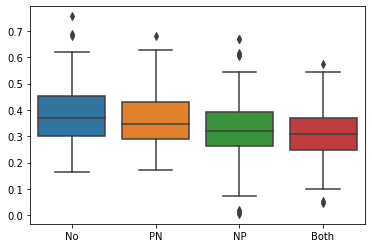

In [28]:
f = sns.boxplot(data=df);

In [29]:
f.get_figure().savefig("figures/Noise Type.svg",format='svg')